<img src="https://blogs.nvidia.com/wp-content/uploads/2022/03/Transformer-model-example-aidan-gomez-672x400.jpg" width="500px">

- **Reference**
    - https://github.com/MyungKyuYi/HAR/blob/main/Transformer_WISDM_1204.ipynb
    - https://keras.io/examples/timeseries/timeseries_classification_transformer/
    - https://blogs.nvidia.co.kr/blog/what-is-a-transformer-model/
    
transformer를 사용한다. 
1. **Self-Attention Mechanism**: 입력 시퀀스의 각 요소 간의 관계를 학습하여 문맥 정보를 파악한다.
2. **Multi-Head Attention**: 여러 개의 self-attention을 병렬로 실행하여 다양한 표현을 학습한다.
3. **Position Encoding**: 위치 정보를 추가하여 순차적인 데이터를 처리한다.
4. **Feed-Forward Neural Networks**: 각 attention layer 후에 비선형 변환을 수행한다.
5. **Layer Normalization 및 Residual Connection**: 학습 안정화를 위해 정규화와 잔차 연결을 사용한다.
6. **Encoder-Decoder Architecture**: 인코더와 디코더 구조로 입력을 처리하고 출력을 생성한다.

Transformer는 기계 번역, 텍스트 요약 등 다양한 분야에 활용되며, BERT, GPT와 같은 파생 모델이 개발되었다.

In [208]:
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit
from scipy.stats import skew
import os
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import numpy as np
import scipy
from tqdm import tqdm

In [209]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# cnn model vary kernel size
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from matplotlib import pyplot
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from keras.utils import to_categorical

import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Reshape, LSTM, Conv1D, MaxPooling1D
from tensorflow.keras.layers import TimeDistributed, Conv1D, MaxPooling1D


---

In [210]:
# data load

df = pd.read_csv("../../class/data/DSA_features.csv")
df

,T_xacc_mean,T_xacc_max,T_xacc_min,T_xacc_var,T_xacc_std,T_xacc_skew,T_yacc_mean,T_yacc_max,T_yacc_min,T_yacc_var,...,LL_ymag_std,LL_ymag_skew,LL_zmag_mean,LL_zmag_max,LL_zmag_min,LL_zmag_var,LL_zmag_std,LL_zmag_skew,activity,people
0,7.975714,8.1605,7.6823,0.014395,0.119981,-0.023319,1.083150,1.1832,0.99744,0.002208,...,0.000792,0.177075,-0.057119,-0.054963,-0.059241,6.778722e-07,0.000823,0.036729,sitting,p1
1,7.978250,8.1763,7.8472,0.007551,0.086896,0.552416,1.140865,1.2129,1.05810,0.000784,...,0.000860,-0.286918,-0.057268,-0.054945,-0.059589,7.032302e-07,0.000839,0.347471,sitting,p1
2,7.970894,8.0860,7.8470,0.003092,0.055603,0.100538,1.140962,1.2128,1.07960,0.000508,...,0.000762,-0.134430,-0.057068,-0.054711,-0.059065,6.268222e-07,0.000792,0.045579,sitting,p1
3,7.938412,8.1083,7.6901,0.003763,0.061343,-0.231914,1.165260,1.3170,1.07870,0.002173,...,0.000735,0.021485,-0.056422,-0.053670,-0.058310,8.011245e-07,0.000895,0.240690,sitting,p1
4,7.908930,8.1305,7.8322,0.001741,0.041731,2.042285,1.187504,1.2574,1.09450,0.000662,...,0.000824,-0.148229,-0.055801,-0.053313,-0.057815,6.853423e-07,0.000828,0.258429,sitting,p1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9115,8.280854,34.1980,-2.9038,28.080803,5.299132,1.350075,-1.491537,11.2240,-11.65100,14.670334,...,0.200829,-0.040701,0.297666,0.708480,-0.117430,4.135451e-02,0.203358,-0.310022,basketBall,p8
9116,9.591118,51.6970,-3.4129,35.722025,5.976791,2.981144,0.086304,6.9951,-11.76400,5.329897,...,0.148745,-0.266377,0.224716,0.554670,-0.250950,3.355704e-02,0.183186,-0.736410,basketBall,p8
9117,9.599113,27.9300,-1.0765,48.850886,6.989341,0.449237,-0.728367,3.7801,-8.36910,5.683022,...,0.310748,-0.009505,-0.237786,0.088854,-0.477260,2.026107e-02,0.142341,0.668438,basketBall,p8
9118,9.692482,72.7820,-2.6734,59.378336,7.705734,4.491114,-0.582724,6.1216,-8.85710,4.162963,...,0.156493,0.050624,0.533023,0.677800,0.055941,1.356379e-02,0.116464,-1.482489,basketBall,p8


In [211]:
# data info, describe

df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9120 entries, 0 to 9119
Columns: 272 entries, T_xacc_mean to people
dtypes: float64(270), object(2)
memory usage: 18.9+ MB


,T_xacc_mean,T_xacc_max,T_xacc_min,T_xacc_var,T_xacc_std,T_xacc_skew,T_yacc_mean,T_yacc_max,T_yacc_min,T_yacc_var,...,LL_ymag_min,LL_ymag_var,LL_ymag_std,LL_ymag_skew,LL_zmag_mean,LL_zmag_max,LL_zmag_min,LL_zmag_var,LL_zmag_std,LL_zmag_skew
count,9120.000000,9120.000000,9120.000000,9120.000000,9120.000000,9120.000000,9120.000000,9120.000000,9120.000000,9120.000000,...,9120.000000,9.120000e+03,9120.000000,9120.000000,9120.000000,9120.000000,9120.000000,9.120000e+03,9120.000000,9120.000000
mean,7.765766,14.625536,3.602974,17.807013,2.454290,0.305587,-0.811036,1.801847,-3.704204,2.049747,...,0.111347,1.818862e-02,0.105897,-0.055440,0.064504,0.169687,-0.052866,7.624694e-03,0.059342,-0.089861
std,3.758022,11.823448,5.622855,45.188787,3.432895,0.768360,2.201692,4.177165,3.982579,3.908675,...,0.362373,2.382393e-02,0.083518,0.526959,0.346660,0.360190,0.359712,1.903445e-02,0.064059,0.619636
min,-11.575660,-4.758700,-99.715000,0.000135,0.011633,-7.826631,-9.782885,-9.703600,-49.941000,0.000141,...,-0.901760,3.044156e-07,0.000552,-3.693948,-0.912397,-0.910830,-1.126000,2.960874e-07,0.000544,-5.111532
25%,8.374161,9.523200,0.000000,0.036855,0.191977,-0.161535,-1.134192,0.172375,-4.837875,0.012121,...,-0.111835,5.683172e-04,0.023839,-0.343123,-0.156271,-0.035821,-0.326125,2.227543e-04,0.014925,-0.402781
50%,9.186328,12.549500,5.757900,2.241468,1.497153,0.275042,-0.375678,1.571750,-2.470150,0.737663,...,0.184470,1.078612e-02,0.103856,-0.075786,0.086285,0.210825,-0.040447,1.813539e-03,0.042586,-0.092036
75%,9.515573,15.843250,7.649075,6.680571,2.584680,0.845410,0.127612,3.005450,-1.279725,1.900426,...,0.315962,2.740661e-02,0.165549,0.177076,0.295415,0.422270,0.206933,6.927870e-03,0.083234,0.228493
max,10.713139,93.694000,9.749000,392.898630,19.821671,9.070164,7.051530,41.013000,2.656400,54.332000,...,0.969020,3.041940e-01,0.551538,5.035185,1.020691,1.042600,0.999440,2.790198e-01,0.528223,3.560828


In [212]:
# 결측치 처리

print (df.isnull().sum())
df = df.dropna()
print ()
print (df.isnull().sum())

T_xacc_mean     0
T_xacc_max      0
T_xacc_min      0
T_xacc_var      0
T_xacc_std      0
               ..
LL_zmag_var     0
LL_zmag_std     0
LL_zmag_skew    0
activity        0
people          0
Length: 272, dtype: int64

T_xacc_mean     0
T_xacc_max      0
T_xacc_min      0
T_xacc_var      0
T_xacc_std      0
               ..
LL_zmag_var     0
LL_zmag_std     0
LL_zmag_skew    0
activity        0
people          0
Length: 272, dtype: int64


In [213]:
# attribute가 무엇으로 구성되어 있는지 확인

print (df.columns)

'''
    attribute가 무려 271개나 있다. (activity 제외 / activity가 여기서 target값이 되겠다)
'''

Index(['T_xacc_mean', 'T_xacc_max', 'T_xacc_min', 'T_xacc_var', 'T_xacc_std',
       'T_xacc_skew', 'T_yacc_mean', 'T_yacc_max', 'T_yacc_min', 'T_yacc_var',
       ...
       'LL_ymag_std', 'LL_ymag_skew', 'LL_zmag_mean', 'LL_zmag_max',
       'LL_zmag_min', 'LL_zmag_var', 'LL_zmag_std', 'LL_zmag_skew', 'activity',
       'people'],
      dtype='object', length=272)


'\n    attribute가 무려 271개나 있다. (activity 제외 / activity가 여기서 target값이 되겠다)\n'

In [214]:
# people 열 제거

df = df.drop('people', axis=1)

In [215]:
# target값인 df['activity']의 각 클래스별 갯수 확인 

df['activity'].value_counts()

activity
sitting                    480
walkingTreadmillIncline    480
jumping                    480
rowing                     480
cyclingVertical            480
cyclingHorizontal          480
crossTrainer               480
stepper                    480
runningTreadmill           480
walkingTreadmillFlat       480
standing                   480
walkingLot                 480
movingInElevator           480
standingInElevatorStill    480
decendingStairs            480
ascendingStairs            480
lyingRigh                  480
lyingBack                  480
basketBall                 480
Name: count, dtype: int64

'\n    모든 class가 480개로 빈도수가 동일하기 때문에 클래스 편향이 일어나지 않을 것이다.\n'

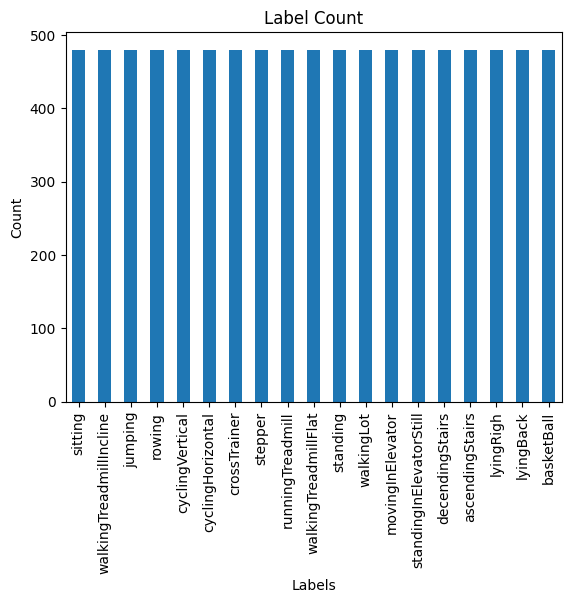

In [216]:
# countplot

import pandas as pd
import matplotlib.pyplot as plt

# 레이블별 갯수 확인
label_counts = df['activity'].value_counts()

# 바 그래프 그리기
label_counts.plot(kind='bar')

# 그래프 제목 및 라벨 설정
plt.title('Label Count')
plt.xlabel('Labels')
plt.ylabel('Count')

'''
    모든 class가 480개로 빈도수가 동일하기 때문에 클래스 편향이 일어나지 않을 것이다.
'''

In [217]:
# target 값이 현재 문자열로 이루어져 있기 때문에 label encoding을 통하여 0-based로 된 class로 remapping

from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
df['activity'] = label_encoder.fit_transform(df['activity'])

In [218]:
# label encoding된 결과 확인

print (df['activity'].value_counts())

activity
12    480
18    480
6     480
10    480
4     480
3     480
2     480
15    480
11    480
17    480
13    480
16    480
9     480
14    480
5     480
0     480
8     480
7     480
1     480
Name: count, dtype: int64


In [219]:
# input, target split

df_Y = df['activity'] 
df_X = df.drop ('activity', axis=1)
print  (df_X.head(10))

   T_xacc_mean  T_xacc_max  T_xacc_min  T_xacc_var  T_xacc_std  T_xacc_skew  \
0     7.975714      8.1605      7.6823    0.014395    0.119981    -0.023319   
1     7.978250      8.1763      7.8472    0.007551    0.086896     0.552416   
2     7.970894      8.0860      7.8470    0.003092    0.055603     0.100538   
3     7.938412      8.1083      7.6901    0.003763    0.061343    -0.231914   
4     7.908930      8.1305      7.8322    0.001741    0.041731     2.042285   
5     7.965544      8.1304      7.8691    0.004233    0.065059     0.576279   
6     7.923159      8.0482      7.8543    0.001490    0.038600     0.807007   
7     7.941025      8.0559      7.8468    0.003056    0.055283     0.284582   
8     7.882650      8.0483      7.6304    0.009832    0.099157    -0.062036   
9     7.902089      8.0484      7.8318    0.002280    0.047751     0.680589   

   T_yacc_mean  T_yacc_max  T_yacc_min  T_yacc_var  ...  LL_ymag_min  \
0     1.083150      1.1832     0.99744    0.002208  ...   

In [220]:
# train, test, split

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_X, 
                                                    df_Y,
                                                    test_size = 0.5, 
                                                    random_state = 21)

print (X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(4560, 270) (4560, 270) (4560,) (4560,)


In [221]:
'''
    순환 데이터를 구성하기 위하여 split_sequences를 사용하였다.
    이때, 각 window마다 class의 빈도 수를 측정하여 가장 많은 빈도수를 가진 class가 target이 되는 방식을 취하였다.
'''

# from collections import Counter
# import numpy as np

# def split_sequences(sequences, n_steps):
#     X, y = list(), list()  # 빈 리스트를 생성하여 시퀀스 데이터와 레이블을 담을 공간을 만듦
#     for i in range(len(sequences)):  # 전체 시퀀스 데이터를 순회
#         # find the end of this pattern
#         end_ix = i + n_steps  # 현재 인덱스(i)에서 n_steps만큼 떨어진 시퀀스의 끝을 계산
#         # check if we are beyond the dataset
#         if end_ix > len(sequences):  # 시퀀스 끝이 데이터의 범위를 넘어서는지 확인
#             break  # 범위를 넘으면 루프 종료
#         # gather input (X) and output parts (y)
#         seq_x = sequences[i:end_ix, :-1]  # 입력 데이터 (특징 데이터)
#         seq_y_values = sequences[i:end_ix, -1]  # 시퀀스 동안의 출력 데이터 (레이블들)
        
#         # 가장 빈번하게 나온 레이블 찾기
#         most_common_label = Counter(seq_y_values).most_common(1)[0][0]
        
#         X.append(seq_x)  # 입력 데이터 추가
#         y.append(most_common_label)  # 가장 많이 나온 레이블 추가
    
#     return np.array(X), np.array(y)  # 리스트를 numpy 배열로 변환하여 반환

'\n    순환 데이터를 구성하기 위하여 split_sequences를 사용하였다.\n    이때, 각 window마다 class의 빈도 수를 측정하여 가장 많은 빈도수를 가진 class가 target이 되는 방식을 취하였다.\n'

In [222]:
# # X_train_seq_RA, y_train_seq_RA, X_test_seq_RA, y_test_seq_RA 구성

# # Merge train and test X/y data to apply sequence transformation function
# y_train_array = np.array(y_train)
# train_set = np.c_[X_train, y_train_array]

# y_test_array = np.array(y_test)
# test_set = np.c_[X_test, y_test_array]

# n_step = 3  # window 사이즈는 3로 한다
 
# X_train_seq, y_train_seq = split_sequences(train_set, n_step)
# print(X_train_seq.shape, y_train_seq.shape)

# X_test_seq, y_test_seq = split_sequences(test_set, n_step)
# print(X_test_seq.shape, y_test_seq.shape)

In [223]:
from keras.preprocessing.sequence import pad_sequences

# 패딩 추가 (필요한 경우)
desired_feature_count = 60  # 예시로 20 x 3 = 60
X_train_padded = pad_sequences(X_train.values, maxlen=desired_feature_count, padding='post', dtype='float32')
X_test_padded = pad_sequences(X_test.values, maxlen=desired_feature_count, padding='post', dtype='float32')

# reshape for CNN
X_train_reshaped = X_train_padded.reshape(-1, 20, 3)
X_test_reshaped = X_test_padded.reshape(-1, 20, 3)

# 확인
print(X_train_reshaped.shape)  # (samples, 20, 3)
print(X_test_reshaped.shape)

(4560, 20, 3)
(4560, 20, 3)


In [224]:
# one hot encoding을 진행한다. (categorical crossentropy)

from keras.utils import to_categorical

# Convert output variables to categorical for CNN
y_train_encoded = to_categorical(y_train)
y_test_encoded = to_categorical(y_test)


-----

In [225]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (BatchNormalization, Conv1D, Activation, Flatten, Dense, 
                                     Reshape, TimeDistributed, MaxPooling1D, LSTM, Dropout, 
                                     Bidirectional, Input, GlobalAveragePooling1D, Concatenate, 
                                     MaxPool1D, Add)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.losses import CategoricalCrossentropy

In [226]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Attention and Normalization
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(inputs, inputs)
    x = layers.Dropout(dropout)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    res = x + inputs  # Residual Connection

    # Feed Forward Part
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(res)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    x = layers.Dropout(dropout)(x)  # Dropout added here
    x = layers.LayerNormalization(epsilon=1e-6)(x)  
    return x + res  # Residual Connection again

In [227]:
"""
The main part of our model is now complete. We can stack multiple of those
`transformer_encoder` blocks and we can also proceed to add the final
Multi-Layer Perceptron classification head. Apart from a stack of `Dense`
layers, we need to reduce the output tensor of the `TransformerEncoder` part of
our model down to a vector of features for each data point in the current
batch. A common way to achieve this is to use a pooling layer. For
this example, a `GlobalAveragePooling1D` layer is sufficient.
"""


def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
    n_classes=0
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    
    outputs = layers.Dense(n_classes, activation="softmax")(x)
    return keras.Model(inputs, outputs)

In [228]:
# modeling

input_shape = (X_train_reshaped.shape[1], X_train_reshaped.shape[2])

transformer = build_model(
    input_shape,
    head_size=256,
    num_heads=8,
    ff_dim=128,  # Increased feed-forward dimension
    num_transformer_blocks=6,  # Increased number of transformer blocks
    mlp_units=[350, 250],  # Increased MLP complexity
    mlp_dropout=0.2,
    dropout=0.2,
    n_classes=19
)

In [229]:
# compile

optimizer = keras.optimizers.Adam(learning_rate=0.001)
transformer.compile(
    loss="categorical_crossentropy",
    optimizer=optimizer,
    #metrics=["sparse_categorical_accuracy"],
    metrics=["accuracy"],
    run_eagerly=True
)

In [230]:
# fit

from memory_profiler import profile

@profile # 메모리 오버플로우로 인한 시스템 다운을 막기 위해서
def train_model(model, X, y) :
#     early_stopping_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
    
    history = model.fit(X, y, epochs=5, 
                        validation_split=0.2,
                        batch_size=128,
#                         callbacks=[early_stopping_cb], 
                        verbose=True, shuffle=True)
    
    return history

history = train_model(transformer, X_train_reshaped, y_train_encoded)


ERROR: Could not find file /var/folders/_z/gryfr07n59jgb3wrd062h1ym0000gn/T/ipykernel_76213/3210489736.py
Epoch 1/5
29/29 ━━━━━━━━━━━━━━━━━━━━ 82s 3s/step - accuracy: 0.2712 - loss: 2.4613 - val_accuracy: 0.6458 - val_loss: 1.0956
Epoch 2/5
29/29 ━━━━━━━━━━━━━━━━━━━━ 82s 3s/step - accuracy: 0.5876 - loss: 1.1828 - val_accuracy: 0.7555 - val_loss: 0.7315
Epoch 3/5
29/29 ━━━━━━━━━━━━━━━━━━━━ 82s 3s/step - accuracy: 0.7045 - loss: 0.8262 - val_accuracy: 0.8257 - val_loss: 0.5416
Epoch 4/5
29/29 ━━━━━━━━━━━━━━━━━━━━ 84s 3s/step - accuracy: 0.7851 - loss: 0.6185 - val_accuracy: 0.8947 - val_loss: 0.3482
Epoch 5/5
29/29 ━━━━━━━━━━━━━━━━━━━━ 84s 3s/step - accuracy: 0.8361 - loss: 0.4646 - val_accuracy: 0.8947 - val_loss: 0.3183


{'accuracy': [0.39391446113586426, 0.6118420958518982, 0.7223135828971863, 0.8018091917037964, 0.8382675647735596], 'loss': [1.9402402639389038, 1.0812243223190308, 0.7774020433425903, 0.5750584602355957, 0.4441356360912323], 'val_accuracy': [0.6458333134651184, 0.7554824352264404, 0.8256579041481018, 0.8947368264198303, 0.8947368264198303], 'val_loss': [1.0956348180770874, 0.7315252423286438, 0.5416284799575806, 0.3481932580471039, 0.3183249235153198]}


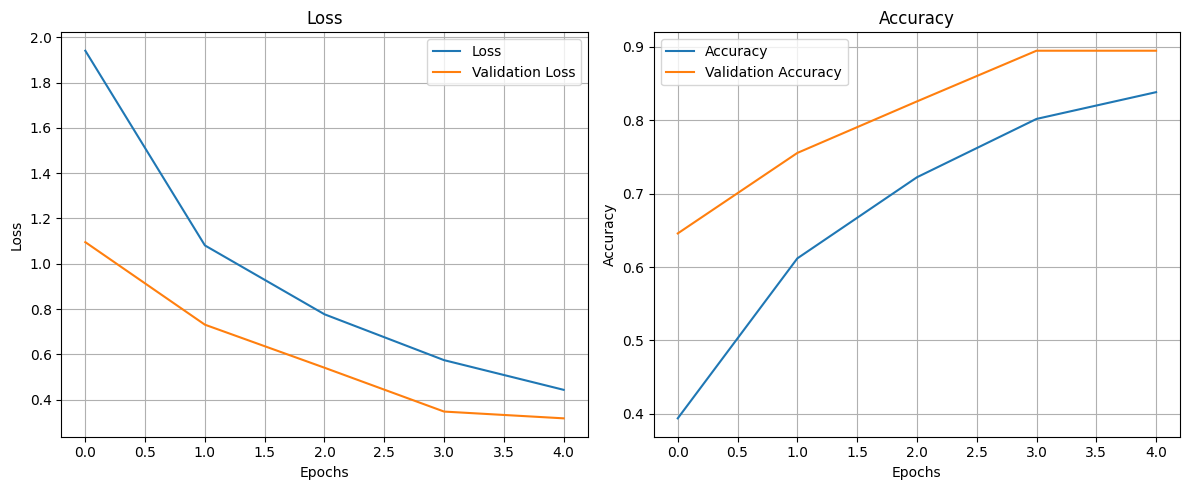

In [231]:
# loss와 validation loss, acc와 validation acc를 시각화하기 위한 메소드

print (history.history)

def draw_history (history) :
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    ax[0].plot(history.history['loss'], label='Loss')
    ax[0].plot(history.history['val_loss'], label='Validation Loss')
    ax[0].set_title('Loss')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].legend()
    ax[0].grid()

    ax[1].plot(history.history['accuracy'], label='Accuracy')
    ax[1].plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax[1].set_title('Accuracy')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend()
    ax[1].grid()

    plt.tight_layout()
    plt.show()

draw_history(history)

In [233]:
# evaulate

print ("train score : ", transformer.evaluate(X_train_reshaped, y_train_encoded))
print ("test score : ", transformer.evaluate(X_test_reshaped, y_test_encoded))

eval = transformer.evaluate(X_test_reshaped, y_test_encoded)

print(eval)

143/143 ━━━━━━━━━━━━━━━━━━━━ 39s 271ms/step - accuracy: 0.9045 - loss: 0.3069
train score :  [0.3080064654350281, 0.902193009853363]
143/143 ━━━━━━━━━━━━━━━━━━━━ 38s 265ms/step - accuracy: 0.8917 - loss: 0.3400
test score :  [0.3300812542438507, 0.8910087943077087]
143/143 ━━━━━━━━━━━━━━━━━━━━ 38s 263ms/step - accuracy: 0.8917 - loss: 0.3400
[0.3300812542438507, 0.8910087943077087]


143/143 ━━━━━━━━━━━━━━━━━━━━ 36s 250ms/step
Confusion Matrix


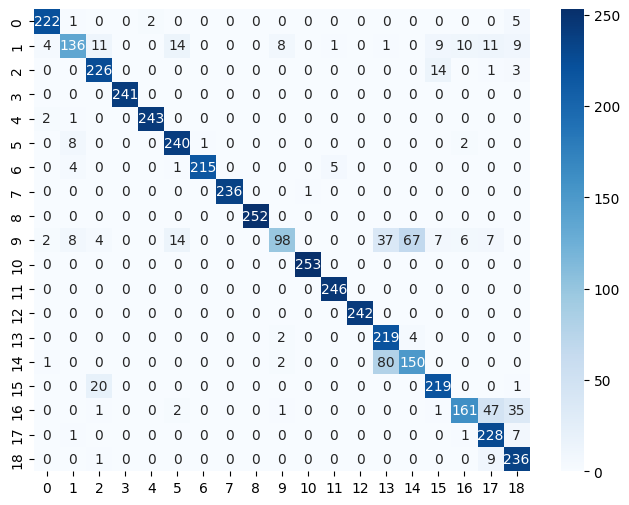

              precision    recall  f1-score   support

           0       0.96      0.97      0.96       230
           1       0.86      0.64      0.73       214
           2       0.86      0.93      0.89       244
           3       1.00      1.00      1.00       241
           4       0.99      0.99      0.99       246
           5       0.89      0.96      0.92       251
           6       1.00      0.96      0.98       225
           7       1.00      1.00      1.00       237
           8       1.00      1.00      1.00       252
           9       0.88      0.39      0.54       250
          10       1.00      1.00      1.00       253
          11       0.98      1.00      0.99       246
          12       1.00      1.00      1.00       242
          13       0.65      0.97      0.78       225
          14       0.68      0.64      0.66       233
          15       0.88      0.91      0.89       240
          16       0.89      0.65      0.75       248
          17       0.75    

In [234]:
# confusion matrix, classification report, accuracy

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

y_test_arg = np.argmax(y_test_encoded, axis=1)
Y_pred = np.argmax(transformer.predict(X_test_reshaped) ,axis=1)
print ('Confusion Matrix')
cm = confusion_matrix(y_test_arg, Y_pred)

# confusion matrix 시각화
plt.figure(figsize=(8, 6))  # 그래프 크기 조절 (너비 8, 높이 6)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.show()

# classification report
report = classification_report(y_test_arg, Y_pred)
print (report)